In [11]:
import os
import pandas as pd

# 設定參數
folder_path = 'data'
window_size = 10  # 窗格大小
stride = 10  # 步長
variables = [
    'GravityX', 'GravityY', 'GravityZ',
    'UserAccelerationX', 'UserAccelerationY', 'UserAccelerationZ',
    'RotationRateX', 'RotationRateY', 'RotationRateZ',
    'AttitudeRoll', 'AttitudePitch', 'AttitudeYaw'
]

# 用於儲存所有資料的清單
all_data = []

# 迭代每個子資料夾
for subfolder_name in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder_name)
    
    if os.path.isdir(subfolder_path):
        for file_name in os.listdir(subfolder_path):
            # 跳過 ._ 開頭的檔案
            if file_name.startswith('._'):
                continue
            
            if file_name.endswith('.csv'):
                file_path = os.path.join(subfolder_path, file_name)
                
                # 嘗試讀取資料，並指定編碼格式
                try:
                    df = pd.read_csv(file_path, encoding='ISO-8859-1')
                except UnicodeDecodeError:
                    print(f"Error reading {file_path}. Skipping this file.")
                    continue
                
                # 計算窗口移動的平均和變異數
                for start in range(0, len(df), stride):
                    end = start + window_size
                    
                    # 若最後一個窗格不足，則用最後的100筆
                    if end > len(df):
                        window_df = df.iloc[-window_size:]
                    else:
                        window_df = df.iloc[start:end]
                    
                    # 計算 mean 和 variance
                    means = window_df[variables].mean().add_suffix('_mean')
                    variances = window_df[variables].var().add_suffix('_var')
                    
                    # 將 mean 和 variance 合併
                    combined = pd.concat([means, variances], axis=0).to_frame().T
                    combined['Label'] = subfolder_name
                    
                    # 加入清單
                    all_data.append(combined)

# 將所有資料合併為單一 DataFrame
final_df = pd.concat(all_data, ignore_index=True)

# 儲存為新的 CSV 檔案
final_df.to_csv('合併的統計資料.csv', index=False)


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import joblib
import os

# 載入資料
data = pd.read_csv('合併的統計資料.csv')  # 替換為您的資料檔案名稱

# 分離特徵和標籤
X = data.drop(columns=['Label'])
y = data['Label']

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 定義模型列表
models = {
    "RandomForest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "MLP": MLPClassifier(),
    "SVM": SVC()
}

# 用於儲存模型性能的字典
results = {}

# 測試每個模型
for model_name, model in models.items():
    # 訓練模型
    model.fit(X_train, y_train)
    
    # 預測
    y_pred = model.predict(X_test)
    
    # 計算混淆矩陣和正確率
    cm = confusion_matrix(y_test, y_pred, labels=y.unique())
    accuracy = accuracy_score(y_test, y_pred)
    
    # 保存混淆矩陣和正確率
    results[model_name] = {
        "Confusion Matrix": cm,
        "Accuracy": accuracy
    }
    
    # 保存模型成 pkl 檔案
    model_filename = f"{model_name}.pkl"
    joblib.dump(model, model_filename)
    
    # 計算模型大小
    model_size = os.path.getsize(model_filename) / 1024  # 以 KB 為單位
    results[model_name]["Model Size (KB)"] = model_size

# 顯示結果
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print("Confusion Matrix:")
    print(result["Confusion Matrix"])
    print(f"Accuracy: {result['Accuracy']:.2f}")
    print(f"Model Size: {result['Model Size (KB)']:.2f} KB\n")


/opt/anaconda3/envs/finlab/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model: RandomForest
Confusion Matrix:
[[4219   11    0   12]
 [  21 1036    1   88]
 [   0    3  234    0]
 [  38   14    0 3413]]
Accuracy: 0.98
Model Size: 10473.29 KB

Model: KNN
Confusion Matrix:
[[4214   10    0   18]
 [  21  982    4  139]
 [   0    1  232    4]
 [  57   27    0 3381]]
Accuracy: 0.97
Model Size: 4144.02 KB

Model: GradientBoosting
Confusion Matrix:
[[4213   14    0   15]
 [  29 1017    1   99]
 [   0    5  232    0]
 [  49   18    0 3398]]
Accuracy: 0.97
Model Size: 704.29 KB

Model: MLP
Confusion Matrix:
[[4220    9    0   13]
 [  44 1012    2   88]
 [   0    2  235    0]
 [  61   23    0 3381]]
Accuracy: 0.97
Model Size: 77.61 KB

Model: SVM
Confusion Matrix:
[[4203    9    0   30]
 [  52  927    9  158]
 [   0    3  234    0]
 [  71   25    0 3369]]
Accuracy: 0.96
Model Size: 689.25 KB



In [13]:
import os
import pandas as pd

# 設定參數
folder_path = 'test'
window_size = 10  # 窗格大小
stride = 10  # 步長
variables = [
    'GravityX', 'GravityY', 'GravityZ',
    'UserAccelerationX', 'UserAccelerationY', 'UserAccelerationZ',
    'RotationRateX', 'RotationRateY', 'RotationRateZ',
    'AttitudeRoll', 'AttitudePitch', 'AttitudeYaw'
]

# 用於儲存所有資料的清單
all_data = []

# 迭代每個子資料夾
for subfolder_name in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder_name)
    
    if os.path.isdir(subfolder_path):
        for file_name in os.listdir(subfolder_path):
            # 跳過 ._ 開頭的檔案
            if file_name.startswith('._'):
                continue
            
            if file_name.endswith('.csv'):
                file_path = os.path.join(subfolder_path, file_name)
                
                # 嘗試讀取資料，並指定編碼格式
                try:
                    df = pd.read_csv(file_path, encoding='ISO-8859-1')
                except UnicodeDecodeError:
                    print(f"Error reading {file_path}. Skipping this file.")
                    continue
                
                # 計算窗口移動的平均和變異數
                for start in range(0, len(df), stride):
                    end = start + window_size
                    
                    # 若最後一個窗格不足，則用最後的100筆
                    if end > len(df):
                        window_df = df.iloc[-window_size:]
                    else:
                        window_df = df.iloc[start:end]
                    
                    # 計算 mean 和 variance
                    means = window_df[variables].mean().add_suffix('_mean')
                    variances = window_df[variables].var().add_suffix('_var')
                    
                    # 將 mean 和 variance 合併
                    combined = pd.concat([means, variances], axis=0).to_frame().T
                    combined['Label'] = subfolder_name
                    
                    # 加入清單
                    all_data.append(combined)

# 將所有資料合併為單一 DataFrame
final_df = pd.concat(all_data, ignore_index=True)

# 儲存為新的 CSV 檔案
final_df.to_csv('test_data.csv', index=False)


In [14]:
import pandas as pd
import joblib
from sklearn.metrics import confusion_matrix, accuracy_score
import os

# 載入處理好格式的測試資料
test_data = pd.read_csv('test_data.csv')  # 替換為您的測試資料檔案名稱
X_test = test_data.drop(columns=['Label'])
y_test = test_data['Label']

# 定義模型名稱列表（對應之前保存的模型）
model_names = ["RandomForest", "KNN", "GradientBoosting", "MLP", "SVM"]

# 用於儲存測試結果的字典
test_results = {}

# 對每個模型進行預測並計算評估指標
for model_name in model_names:
    # 讀取保存的模型
    model_path = f"{model_name}.pkl"
    
    # 檢查模型檔案是否存在
    if not os.path.exists(model_path):
        print(f"Model file {model_path} not found. Skipping {model_name}.")
        continue

    # 加載模型
    model = joblib.load(model_path)
    
    # 使用模型進行預測
    y_pred = model.predict(X_test)
    
    # 計算混淆矩陣和正確率
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    accuracy = accuracy_score(y_test, y_pred)
    
    # 保存測試結果
    test_results[model_name] = {
        "Confusion Matrix": cm,
        "Accuracy": accuracy
    }

# 顯示測試結果
for model_name, result in test_results.items():
    print(f"Model: {model_name}")
    print("Confusion Matrix:")
    print(result["Confusion Matrix"])
    print(f"Accuracy: {result['Accuracy']:.2f}\n")


Model: RandomForest
Confusion Matrix:
[[ 2430     0   463    13]
 [   32   422  2269     0]
 [  102     0   261     6]
 [ 1356     0  1255 14102]]
Accuracy: 0.76

Model: KNN
Confusion Matrix:
[[ 2598     3   281    24]
 [ 2221     0   498     4]
 [  144     6   194    25]
 [  757     0   933 15023]]
Accuracy: 0.78

Model: GradientBoosting
Confusion Matrix:
[[ 2459     0   438     9]
 [  226     0  2497     0]
 [  132     0   223    14]
 [ 1337     0   812 14564]]
Accuracy: 0.76

Model: MLP
Confusion Matrix:
[[ 2195     0   673    38]
 [ 2696     0    22     5]
 [   72     0   260    37]
 [  704     0   730 15279]]
Accuracy: 0.78

Model: SVM
Confusion Matrix:
[[ 2554     0   338    14]
 [ 2723     0     0     0]
 [  136     7   200    26]
 [  732     0   439 15542]]
Accuracy: 0.81



In [19]:
import sys
import os

# 使用當前工作目錄來模擬 `__file__`
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)



import aw_write_model
from aw_write_model import aw_train, detect_action_segments_with_changepoint_voting

In [23]:
data = pd.read_csv('data/Eraser/changyi_combined_part1.csv').iloc[:100,]


In [25]:
data.to_csv('speedtest.csv')

In [26]:
import pandas as pd
import joblib
import time
import numpy as np
from sklearn.metrics import accuracy_score
import os

# 載入測試資料
speedtest_data = pd.read_csv('speedtest.csv')

# 定義要計算的變數
variables = [
    'GravityX', 'GravityY', 'GravityZ',
    'UserAccelerationX', 'UserAccelerationY', 'UserAccelerationZ',
    'RotationRateX', 'RotationRateY', 'RotationRateZ',
    'AttitudeRoll', 'AttitudePitch', 'AttitudeYaw'
]

# 開始計算特徵提取時間
start_time = time.time()

# 計算 mean 和 variance
mean_features = speedtest_data[variables].mean().add_suffix('_mean')
var_features = speedtest_data[variables].var().add_suffix('_var')

# 將 mean 和 variance 合併為單一 DataFrame
feature_df = pd.concat([mean_features, var_features]).to_frame().T

# 計算特徵提取所需時間
feature_extraction_time = time.time() - start_time

# 定義模型名稱列表（對應之前保存的模型）
model_names = ["RandomForest", "KNN", "GradientBoosting", "MLP", "SVM"]

# 用於儲存每個模型的速度測試結果
speed_results = {}

# 對每個模型進行預測並計算時間
for model_name in model_names:
    model_path = f"{model_name}.pkl"
    
    # 檢查模型檔案是否存在
    if not os.path.exists(model_path):
        print(f"Model file {model_path} not found. Skipping {model_name}.")
        continue

    # 加載模型
    model = joblib.load(model_path)
    
    # 開始計算預測時間
    start_time = time.time()
    
    # 預測
    y_pred = model.predict(feature_df)
    
    # 計算預測所需時間
    prediction_time = time.time() - start_time
    
    # 保存特徵提取和預測時間
    total_time = feature_extraction_time + prediction_time
    speed_results[model_name] = {
        "Feature Extraction Time (s)": feature_extraction_time,
        "Prediction Time (s)": prediction_time,
        "Total Time (s)": total_time
    }

# 顯示測試結果
for model_name, result in speed_results.items():
    print(f"Model: {model_name}")
    print(f"Feature Extraction Time: {result['Feature Extraction Time (s)']:.4f} seconds")
    print(f"Prediction Time: {result['Prediction Time (s)']:.4f} seconds")
    print(f"Total Time: {result['Total Time (s)']:.4f} seconds\n")


Model: RandomForest
Feature Extraction Time: 0.0028 seconds
Prediction Time: 0.0031 seconds
Total Time: 0.0060 seconds

Model: KNN
Feature Extraction Time: 0.0028 seconds
Prediction Time: 0.0015 seconds
Total Time: 0.0043 seconds

Model: GradientBoosting
Feature Extraction Time: 0.0028 seconds
Prediction Time: 0.0010 seconds
Total Time: 0.0038 seconds

Model: MLP
Feature Extraction Time: 0.0028 seconds
Prediction Time: 0.0004 seconds
Total Time: 0.0032 seconds

Model: SVM
Feature Extraction Time: 0.0028 seconds
Prediction Time: 0.0005 seconds
Total Time: 0.0033 seconds



In [28]:
model_dirs = ['/Volumes/Transcend/WriteRec/saved_models/write', '/Volumes/Transcend/WriteRec/saved_models/Eraser','/Volumes/Transcend/WriteRec/saved_models/points']  # 添加您的動作模型文件夾
part_variables = ['GravityX', 'GravityY', 'GravityZ']

file_path = 'speedtest.csv'
start_time = time.time()

# 調用 detect_action_segments_with_changepoint_voting 函數進行預測
pred = detect_action_segments_with_changepoint_voting(file_path=file_path,
                                                      model_dirs = model_dirs,
                                                      segment_size=100,
                                                      min_action_length=150,
                                                      variables = part_variables,
                                                      smooth_labels=False,
                                                      show_image=False
                                                      )
prediction_time = time.time() - start_time
print(f"Prediction Time: {result['Prediction Time (s)']:.4f} seconds")


Eraser 占比: 100.00%
Prediction Time: 0.0005 seconds


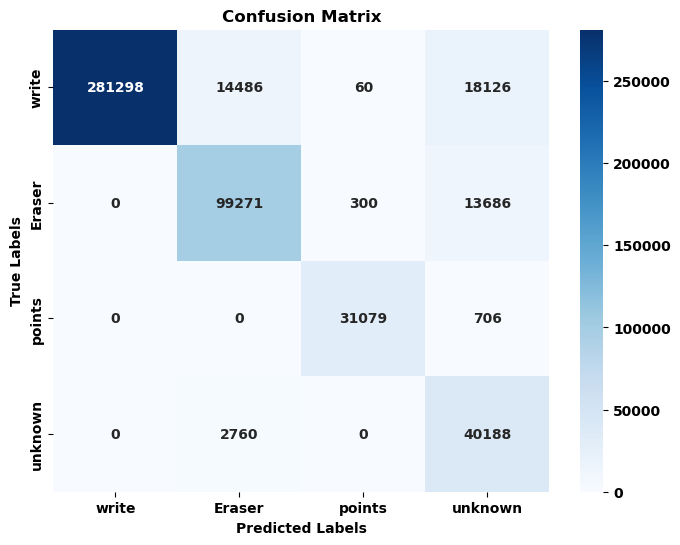

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix data
confusion_matrix = np.array([
    [281298, 14486, 60, 18126],
    [0, 99271, 300, 13686],
    [0, 0, 31079, 706],
    [0, 2760, 0, 40188]
])

# Labels for the classes
labels = ['write', 'Eraser', 'points', 'unknown']

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig("probability density model confusion_matrix_plot.png")
plt.show()


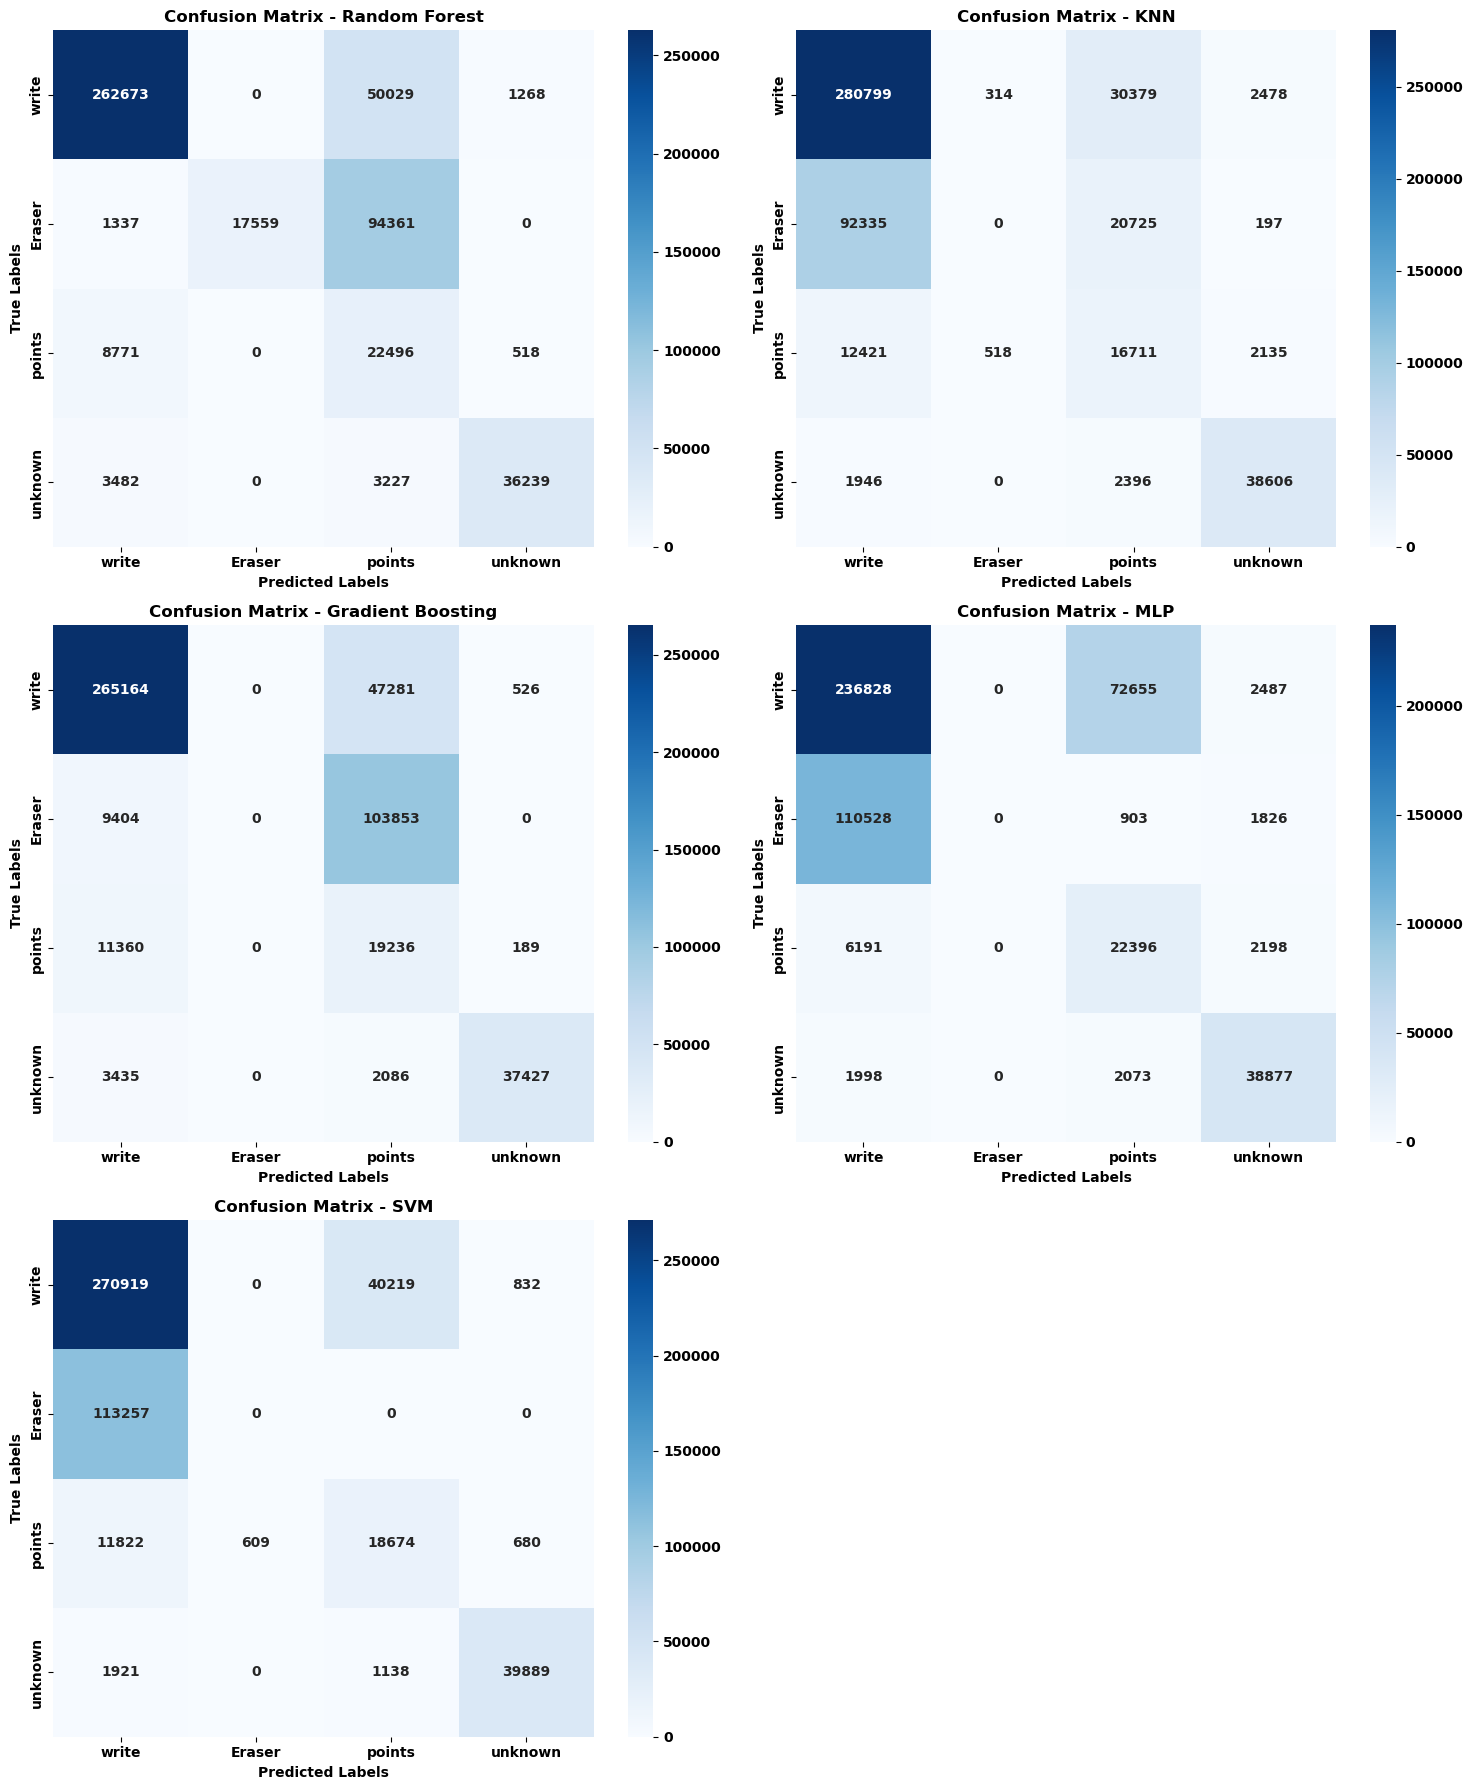

{'Random Forest': 'random_forest_confusion_matrix.png',
 'KNN': 'knn_confusion_matrix.png',
 'Gradient Boosting': 'gradient_boosting_confusion_matrix.png',
 'MLP': 'mlp_confusion_matrix.png',
 'SVM': 'svm_confusion_matrix.png'}

In [6]:
# Defining all confusion matrices and model names
import numpy as np

confusion_matrices = {
    "Random Forest": np.array([
        [262673, 0, 50029, 1268],
        [1337, 17559, 94361, 0],
        [8771, 0, 22496, 518],
        [3482, 0, 3227, 36239]
    ]),
    "KNN": np.array([
        [280799, 314, 30379, 2478],
        [92335, 0, 20725, 197],
        [12421, 518, 16711, 2135],
        [1946, 0, 2396, 38606]
    ]),
    "Gradient Boosting": np.array([
        [265164, 0, 47281, 526],
        [9404, 0, 103853, 0],
        [11360, 0, 19236, 189],
        [3435, 0, 2086, 37427]
    ]),
    "MLP": np.array([
        [236828, 0, 72655, 2487],
        [110528, 0, 903, 1826],
        [6191, 0, 22396, 2198],
        [1998, 0, 2073, 38877]
    ]),
    "SVM": np.array([
        [270919, 0, 40219, 832],
        [113257, 0, 0, 0],
        [11822, 609, 18674, 680],
        [1921, 0, 1138, 39889]
    ])
}


# Labels for the classes
labels = ['write', 'Eraser', 'points', 'unknown']

# Plotting each confusion matrix
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

for i, (model_name, matrix) in enumerate(confusion_matrices.items()):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=axes[i])
    axes[i].set_xlabel("Predicted Labels")
    axes[i].set_ylabel("True Labels")
    axes[i].set_title(f"Confusion Matrix - {model_name}")

# Hide any unused subplots
for j in range(len(confusion_matrices), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("comparative_confusion_matrices.png")
plt.show()

# Saving each confusion matrix individually
file_paths = {}
for model_name, matrix in confusion_matrices.items():
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {model_name}")
    file_path = f"{model_name.replace(' ', '_').lower()}_confusion_matrix.png"
    plt.savefig(file_path)
    file_paths[model_name] = file_path
    plt.close()

file_paths
